<a href="https://colab.research.google.com/github/CatFatOw/Blood_Cell_Segmentation/blob/main/BloodCellSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook creates a PyTorch ML Pipeline to segment blood vessals.

The notebook will be broken in to the following enumerated steps:

1. Viewing and creating the dataset
2. Defining models and hyperparmeters
3. Training model and evaulaion



# Part 1

Part 1 will result in a customized dataset suitable for PyTorch

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jeetblahiri/bccd-dataset-with-mask")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bccd-dataset-with-mask


In [ ]:
# Move the dataset

!mv /kaggle/input/bccd-dataset-with-mask /content/dataset


In [ ]:
pip install segmentation-models-pytorch

In [ ]:
# import necessary libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd, numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import segmentation_models_pytorch as smp
import cv2


# View a random image and corresponding mask

In [ ]:
import os
from tqdm import tqdm

def sorted_file_paths(dir_path):
    return sorted([
        os.path.join(dir_path, f)
        for f in os.listdir(dir_path)
        if not f.startswith('.') and os.path.isfile(os.path.join(dir_path, f))
    ])
# Sort the lists
train_img_list = sorted_file_paths("/content/dataset/BCCD Dataset with mask/train/original")
train_mask_list = sorted_file_paths("/content/dataset/BCCD Dataset with mask/train/mask")

test_img_list = sorted_file_paths("/content/dataset/BCCD Dataset with mask/test/original")
test_mask_list = sorted_file_paths("/content/dataset/BCCD Dataset with mask/test/mask")

# Zip into (image, mask) pairs
train_pairs = list(zip(train_img_list, train_mask_list))
test_pairs = list(zip(test_img_list, test_mask_list))

# Combine
all_pairs = train_pairs + test_pairs


In [ ]:
print(len(img_list), len(mask_list))

1328 1328


In [ ]:
# Create custom df

hash_map = {
    "img_path": img_list,
    "mask_path": mask_list,
}

df = pd.DataFrame(hash_map)
df.head()

,img_path,mask_path
0,/content/dataset/BCCD Dataset with mask/test/o...,/content/dataset/BCCD Dataset with mask/test/m...
1,/content/dataset/BCCD Dataset with mask/test/o...,/content/dataset/BCCD Dataset with mask/test/m...
2,/content/dataset/BCCD Dataset with mask/test/o...,/content/dataset/BCCD Dataset with mask/test/m...
3,/content/dataset/BCCD Dataset with mask/test/o...,/content/dataset/BCCD Dataset with mask/test/m...
4,/content/dataset/BCCD Dataset with mask/test/o...,/content/dataset/BCCD Dataset with mask/test/m...


/content/dataset/BCCD Dataset with mask/train/original/b87fb62d-2c36-4f68-aba9-37fcd7d46eef.png
/content/dataset/BCCD Dataset with mask/train/mask/b87fb62d-2c36-4f68-aba9-37fcd7d46eef.png


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

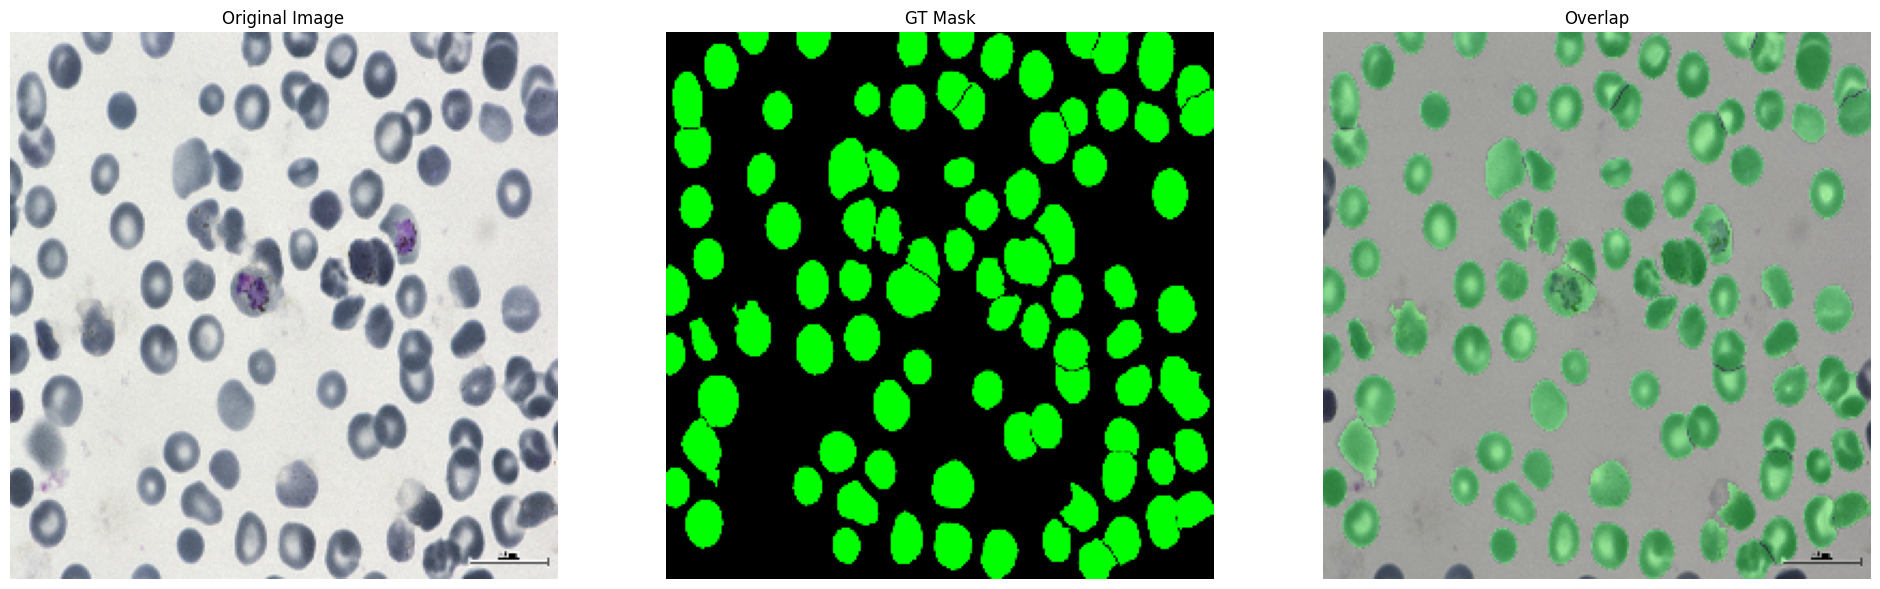

In [ ]:
# Sample a random img and mask
import random

random_index = random.randint(0, len(img_list)-1)
random_img = df["img_path"][random_index]
random_mask = df["mask_path"][random_index]

print(random_img)
print(random_mask)

image = cv2.imread(random_img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256,256))

mask = cv2.imread(random_mask, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))

# Introduce a color to the mask for viewing purposes
colored_mask = np.zeros((256,256,3), dtype=np.uint8)
colored_mask[:,:,1] = mask

overlay = image.copy()
overlay = cv2.addWeighted(overlay, 0.7, colored_mask, 0.3, 0)


# Create the matplotlib figure
plt.figure(figsize=(24,8))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("GT Mask")
plt.imshow(colored_mask)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Overlap")
plt.imshow(overlay)
plt.axis("off")

In [ ]:
train = df.sample(frac=0.8)
temp = df.drop(train.index)

val = temp.sample(frac=0.8)
test = temp.drop(val.index)

print(len(train), len(val), len(test))


train_img = train["img_path"].tolist()
train_mask = train["mask_path"].tolist()

val_img = val["img_path"].tolist()
val_mask = val["mask_path"].tolist()

test_img = test["img_path"].tolist()
test_mask = test["mask_path"].tolist()

1062 213 53


# Create custom dataset and dataloader

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.RandomCrop(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
    A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.SmallestMaxSize(max_size=256),
    A.CenterCrop(height=256, width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
class BloodVesselDataset(Dataset):
  def __init__(self, img_path, mask_path, transform):
    self.img_path = img_path
    self.mask_path = mask_path
    self.transform = transform

  def __len__(self):
    return len(self.img_path)

  def __getitem__(self, idx):
    image = self.img_path[idx]
    mask = self.mask_path[idx]

    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (256,256))

    mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256,256))

    augmented = self.transform(image=image, mask=mask)
    image = augmented["image"]
    mask = augmented["mask"]

    mask = mask.unsqueeze(dim=0)
    mask = mask.float()

    return image, mask / 255.0



In [ ]:
train_dataset = BloodVesselDataset(train_img, train_mask, train_transform)
val_dataset = BloodVesselDataset(val_img, val_mask, val_transform)
test_dataset = BloodVesselDataset(test_img, test_mask, val_transform)

img, mask = train_dataset[0]
print(img.shape, mask.shape)


# Create custom loaders


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

img, mask = next(iter(train_loader))
print(img.shape, mask.shape)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
torch.Size([32, 3, 256, 256]) torch.Size([32, 1, 256, 256])


# Part 2: Creating Custom Segmentation Model and Hyperparameters

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# custom model
model = smp.DeepLabV3Plus(encoder_name="resnet101", encoder_weights="imagenet", in_channels=3, classes=1,
                          activation=None,
                          )

model = model.to(device)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3, weight_decay=0.05)


# Custom Segmentation Metrics

In [ ]:
class SegmentationMetrics(nn.Module):
  def __init__(self, threshold=0.5):
    super().__init__()
    self.threshold = threshold

  def forward(self, preds, targets):
    """
    preds: raw output (b, 1, h, w)
    targets: gt mask (b, 1, h, w)
    """
    # We wanna binarize the pred
    preds = torch.sigmoid(preds)
    preds = (preds >= self.threshold).float()

    targets = targets.float()


    # flatten for metric computation
    preds_flat = preds.view(preds.size(0), -1)
    targets_flat = targets.view(targets.size(0), -1)


    # Intersection and union
    intersection = (preds_flat * targets_flat).sum(dim=1)
    union = preds_flat.sum(dim=1) + targets_flat.sum(dim=1) - intersection


    # Calculate the metrics
    iou = (intersection / (union + 1e-7)).mean()
    precision = (intersection / (preds_flat.sum(dim=1) + 1e-7)).mean()
    recall = (intersection / targets_flat.sum(dim=1) + 1e-7).mean()
    f1 = (2 * precision * recall / (precision + recall + 1e-7))

    return {
        "iou": iou.item(),
        "precision": precision.item(),
        "recall": recall.item(),
        "f1": f1.item()
    }





# Training Loop

In [ ]:
def training_loop(n_epochs, model, optimizer, loss_fn, train_loader, val_loader):
    metrics = SegmentationMetrics()

    for epoch in range(1, n_epochs + 1):
        model.train()

        train_total_loss = 0.0
        train_total_iou = 0.0
        train_total_precision = 0.0
        train_total_recall = 0.0
        train_total_f1 = 0.0

        val_total_loss = 0.0
        val_total_iou = 0.0
        val_total_precision = 0.0
        val_total_recall = 0.0
        val_total_f1 = 0.0

        for img, mask in tqdm(train_loader, total=len(train_loader), desc=f"EPOCH: {epoch} [Train]"):
            img, mask = img.to(device), mask.to(device)

            optimizer.zero_grad()
            prediction = model(img)
            train_loss = loss_fn(prediction, mask)
            train_loss.backward()
            optimizer.step()

            train_total_loss += train_loss.item()
            train_metrics = metrics(prediction, mask)
            train_total_iou += train_metrics["iou"]
            train_total_precision += train_metrics["precision"]
            train_total_recall += train_metrics["recall"]
            train_total_f1 += train_metrics["f1"]

        # Average train metrics
        train_len = len(train_loader)
        avg_train_loss = train_total_loss / train_len
        avg_train_iou = train_total_iou / train_len
        avg_train_precision = train_total_precision / train_len
        avg_train_recall = train_total_recall / train_len
        avg_train_f1 = train_total_f1 / train_len

        # Validation
        model.eval()
        with torch.no_grad():
            for img, mask in tqdm(val_loader, total=len(val_loader), desc=f"EPOCH: {epoch} [Val]"):
                img, mask = img.to(device), mask.to(device)

                prediction = model(img)
                val_loss = loss_fn(prediction, mask)
                val_total_loss += val_loss.item()

                val_metrics = metrics(prediction, mask)
                val_total_iou += val_metrics["iou"]
                val_total_precision += val_metrics["precision"]
                val_total_recall += val_metrics["recall"]
                val_total_f1 += val_metrics["f1"]

        val_len = len(val_loader)
        avg_val_loss = val_total_loss / val_len
        avg_val_iou = val_total_iou / val_len
        avg_val_precision = val_total_precision / val_len
        avg_val_recall = val_total_recall / val_len
        avg_val_f1 = val_total_f1 / val_len

        print(f"Epoch {epoch} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f} | IoU: {avg_train_iou:.4f} | Precision: {avg_train_precision:.4f} | Recall: {avg_train_recall:.4f} | F1: {avg_train_f1:.4f}")
        print(f"  Val   Loss: {avg_val_loss:.4f} | IoU: {avg_val_iou:.4f} | Precision: {avg_val_precision:.4f} | Recall: {avg_val_recall:.4f} | F1: {avg_val_f1:.4f}")


In [ ]:
training_loop(4, model, optimizer, loss_fn, train_loader, val_loader)

EPOCH: 1 [Val]: 100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


Epoch 1 Summary:
  Train Loss: 0.2520 | IoU: 0.7322 | Precision: 0.8084 | Recall: 0.8985 | F1: 0.8411
  Val   Loss: 0.2680 | IoU: 0.7463 | Precision: 0.9010 | Recall: 0.8218 | F1: 0.8595


EPOCH: 2 [Val]: 100%|██████████| 7/7 [00:19<00:00,  2.85s/it]


Epoch 2 Summary:
  Train Loss: 0.1392 | IoU: 0.8079 | Precision: 0.8950 | Recall: 0.8965 | F1: 0.8954
  Val   Loss: 0.1314 | IoU: 0.8234 | Precision: 0.9115 | Recall: 0.8961 | F1: 0.9037


EPOCH: 3 [Val]: 100%|██████████| 7/7 [00:19<00:00,  2.79s/it]


Epoch 3 Summary:
  Train Loss: 0.1254 | IoU: 0.8228 | Precision: 0.9033 | Recall: 0.9047 | F1: 0.9037
  Val   Loss: 0.1265 | IoU: 0.8255 | Precision: 0.9292 | Recall: 0.8819 | F1: 0.9049


EPOCH: 4 [Val]: 100%|██████████| 7/7 [00:19<00:00,  2.80s/it]

Epoch 4 Summary:
  Train Loss: 0.1167 | IoU: 0.8346 | Precision: 0.9103 | Recall: 0.9114 | F1: 0.9106
  Val   Loss: 0.1183 | IoU: 0.8332 | Precision: 0.9474 | Recall: 0.8747 | F1: 0.9096


In [ ]:
#torch.save(model.state_dict(), "BloodCell_seg.pt")

# Assess Performance and predict on dataset

In [ ]:
model.eval()
metrics = SegmentationMetrics()
with torch.no_grad():
  loss = 0.0
  iou = 0.0
  precision = 0.0
  recall = 0.0
  f1 = 0.0
  for img, mask in tqdm(test_loader, total=len(test_loader), desc=f"TESTING"):
    img, mask = img.to(device), mask.to(device)

    prediction = model(img)
    test_loss = loss_fn(prediction, mask)
    loss += test_loss.item()

    test_metrics = metrics(prediction, mask)
    iou += test_metrics["iou"]
    precision += test_metrics["precision"]
    recall += test_metrics["recall"]
    f1 += test_metrics["f1"]

print()
print(f"Loss: {loss / len(test_loader):.4f} | IOU: {iou / len(test_loader):.4f} | Precision: {precision / len(test_loader):.4f} | RECALL: {recall / len(test_loader):.4f} | F1: {f1 / len(test_loader):.4f}")



TESTING: 100%|██████████| 2/2 [00:04<00:00,  2.38s/it]


Loss: 0.1219 | IOU: 0.8357 | Precision: 0.9439 | RECALL: 0.8800 | F1: 0.9108


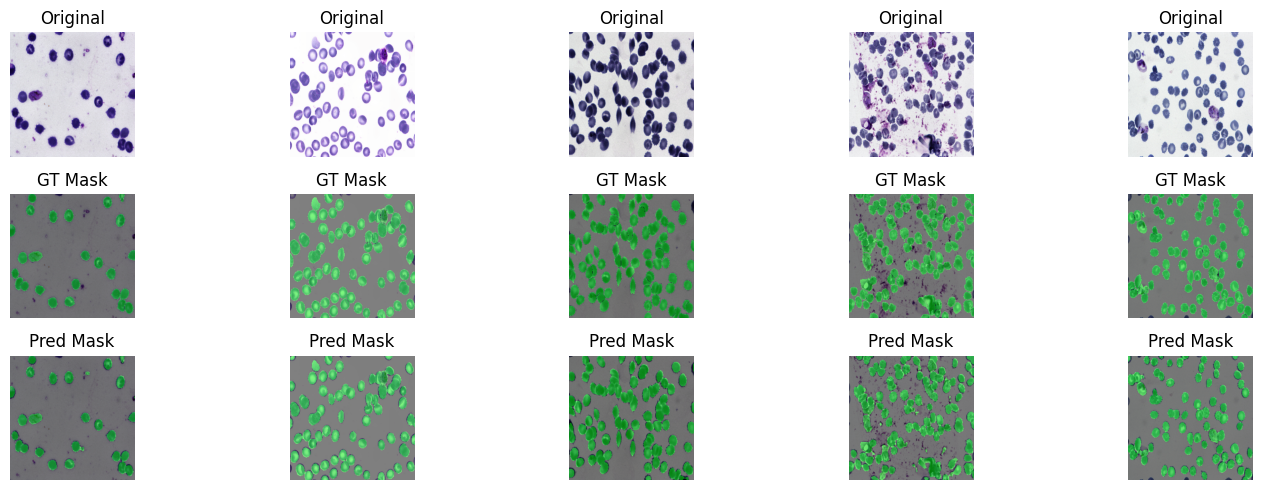

In [ ]:
# Get a batch of 5 images
img_batch, mask_batch = next(iter(test_loader))

# Select first 5
img_batch = img_batch[:5]
mask_batch = mask_batch[:5]

model.eval()
with torch.no_grad():
    predictions = model(img_batch.to(device))
    predictions = torch.sigmoid(predictions)
    pred_masks = (predictions > 0.5).float().cpu()

img_batch = img_batch.cpu()
mask_batch = mask_batch.cpu()

# Unnormalize helper
def unnormalize(img_tensor, mean, std):
    img_tensor = img_tensor.clone()
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

plt.figure(figsize=(15, 5))  # Wider figure

for i in range(5):
    # Unnormalize image
    img = unnormalize(img_batch[i], mean, std).permute(1, 2, 0).numpy()

    # Prepare GT and predicted masks
    mask = mask_batch[i].squeeze().numpy()
    pred_mask = pred_masks[i].squeeze().numpy()

    gt_overlay = img.copy()
    pred_overlay = img.copy()

    # Create GT and pred overlays (green masks)
    gt_mask_color = np.zeros_like(gt_overlay)
    gt_mask_color[:, :, 1] = (mask * 255).astype(np.uint8)

    pred_mask_color = np.zeros_like(pred_overlay)
    pred_mask_color[:, :, 1] = (pred_mask * 255).astype(np.uint8)

    # Plot original
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title("Original")
    plt.axis("off")

    # Plot GT overlay
    plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(img)
    plt.imshow(gt_mask_color, alpha=0.5)
    plt.title("GT Mask")
    plt.axis("off")

    # Plot prediction overlay
    plt.subplot(3, 5, i + 1 + 10)
    plt.imshow(img)
    plt.imshow(pred_mask_color, alpha=0.5)
    plt.title("Pred Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()
